    task prev_task  par  trial failure
61     F         T  P01   icuA       S
62     S         F  P01   icuA       S
101    T         F  P01   icuA       S
102    S         T  P01   icuA       S
120    T         S  P01   icuA       S
..   ...       ...  ...    ...     ...
45     S         T  P25  icuaB       S
48     S         T  P25  icuaB       S
49     T         S  P25  icuaB       S
50     S         T  P25  icuaB       S
55     F         S  P25  icuaB       S

[2558 rows x 5 columns]


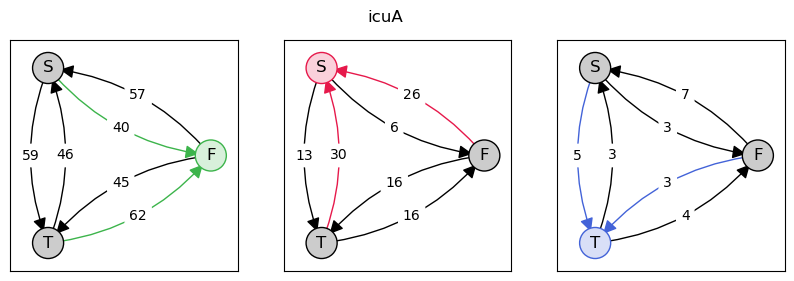

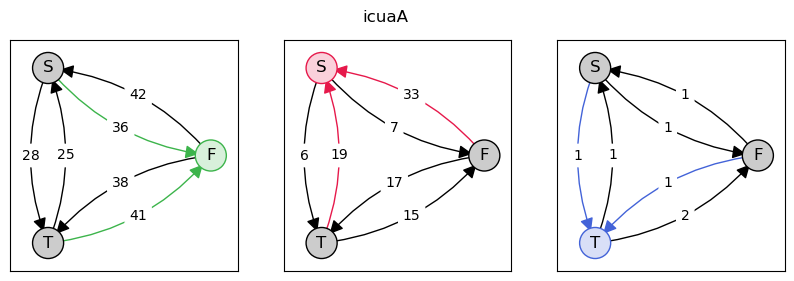

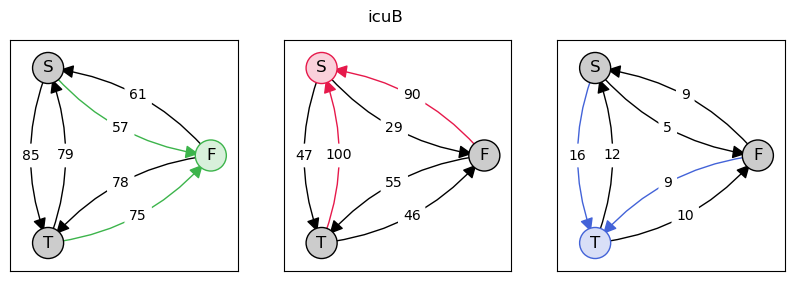

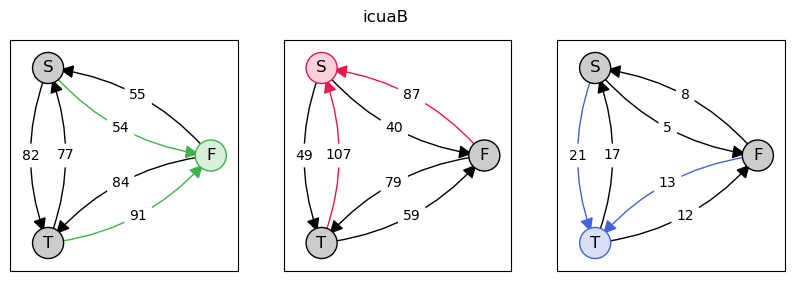

In [11]:
import icua_analysis as ia
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

GRACE_PERIOD = 2


def get_transitions_gt_grace_period():
    for (par, trial), data in ia.load_tabularised().has_eyetracking():
        lintervals = ia.get_fixation_intervals(data)
        fintervals = ia.get_failure_intervals(data) # these are overlapping by task
        
        # for each transition point (task switch), we want to find the length of each task failure
        # first remove "N" task
        lintervals = lintervals[lintervals['task'] != 'N']
        # now remove subsequent duplicates (if they look away then back again without visiting another task)
        lintervals = lintervals[lintervals['task'].ne(lintervals['task'].shift())]
        # compute the previous tasks
        lintervals['prev_task'] = lintervals['task'].shift()
        lintervals = lintervals.loc[1:].reset_index(drop=True)
        #lintervals['index'] = lintervals.index

        #print(lintervals)

        # for each transition point ("t1" in the looking interval), check how long each failure is
        for task, ftintervals in fintervals.groupby('task'):
            ftintervals = ftintervals.reset_index(drop=True) # required for "get_non_overlapping_interval_indices" to provide the correct indices

            # these indices indicate for which failure interval the looking transition happened in (-1 for no failure interval)
            indices = ia.get_non_overlapping_interval_indices(ftintervals[['t1','t2']].to_numpy(), lintervals['t1'].to_numpy())

            # take only those transition points that happen when a failure is occuring.
            _ft = ftintervals.iloc[indices[indices >= 0]].reset_index(drop=True)
            _l = lintervals.iloc[indices >= 0]

            # take only those transitions that are to the task that is in failure
            # indx = _ft['task'].to_numpy() == _l['task'].to_numpy() # _ft['task'] == task
            # _ft, _l = _ft.iloc[indx], _l.iloc[indx]

            # take the transitions that happen after a failure has been happening for > GRACE_PERIOD
            # the transition point (_l['t1']) always happens after the start of the failure (_ft['t1'])
            indx = (_l['t1'].to_numpy() - _ft['t1'].to_numpy()) > GRACE_PERIOD
            yield _l.iloc[indx][['task', 'prev_task']].assign(par=par).assign(trial=trial).assign(failure=task)

            
result = pd.concat(get_transitions_gt_grace_period())
print(result)
    

    
for trial, data in sorted(result.groupby('trial'), key=lambda x: x[0][-1]):
    fig, axes = plt.subplots(figsize=(10,3), ncols=len(ia.TASKS))
    fig.suptitle(trial)
    for ax, task in zip(axes.ravel(), ia.TASKS):
        fdata = data[data['failure'] == task]
        node_colors = ["#000000"] * len(ia.TASKS)
        node_colors[ia.TASKS.index(task)] = ia.get_task_properties(task)['color']
        ia.plot_transition_matrix(fdata['prev_task'], fdata['task'], ax=ax, counts=True, node_colors=node_colors)


    
    
    





In [ ]:
import icua_analysis as ia
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

# compute task transition points 

for (par, trial), data in islice(ia.load_tabularised().has_eyetracking().has_guidance(), 1):
    intervals = ia.get_looking_intervals(data)
    print(intervals)
    
    plt.figure(figsize=(50,1))
    ia.plot_task_intervals(intervals)
    
    intervals = ia.get_fixation_intervals(data)
    print(intervals)
    
    #plt.figure(figsize=(50,1))
    ia.plot_task_intervals(intervals)

    



